# Research Network in Hugo Steinhaus Center

In this project we aim to create a network visualisation of research collaborations within Hugo Steinhaus Center. Each node is designated to a researcher. The size of node denotes total number of research papers by the researcher. Node connection denotes collaboration. The size of connection shows how total number of papers they have collaborated on.

This was done as part of the course: Analysis of Unstructured Data for MS Applied Mathematics in PWr (Winter Semester, 2018-2019)

In [1]:
# Packages Required
import urllib.request as u
from bs4 import BeautifulSoup 
import numpy as np
import re
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random
import math as m
from networkx.drawing.nx_pydot import write_dot

## Web Scraping
Our source data is the Publications page of Hugo Steinhaus Center. When we first inspect the HTML code of the page, we see that each research is stored under a list element (\<li\>). We now scrape this data from the web page and parse the data using an HTML parser from BeautifulSoup and store all list elements in a python list. Further manual inspection, our relevant data (research paper by professors) are between list index 38 to 446. 

In [8]:
url = "http://prac.im.pwr.wroc.pl/~hugo/HSC/Publications.html"
page = u.urlopen(url)
soup = BeautifulSoup(page, 'html.parser')
lists = [li for li in soup.find_all("li")]
papers=lists[38:446]
papers[:5]

[<li>
 <font face="Verdana" size="2"><b>M.Magdziarz</b></font> (<font face="Verdana" size="2">2006</font>) <i><font face="Verdana" size="2">"The dependence structure of the solutions of the fractional equations with α-stable noise"</font></i>,
              <font face="Verdana" size="2"> Ph.D. thesis, supervisor: A. Weron</font>.           
              <a href="../publ/MMagdziarzPhD2006.pdf"><img border="0" height="16" src="images/pdf_logo.gif" width="16"/><font color="black" face="Verdana" size="2">Full text PDF (542 KB)</font></a><br/></li>,
 <li>
 <font face="Verdana" size="2"><b>P. Miśta</b></font> (<font face="Verdana" size="2">2006</font>) <i><font face="Verdana" size="2">"Analytical and numerical approach to corporate operational risk modelling"</font></i>,
              <font face="Verdana" size="2"> Ph.D. thesis, supervisor: A. Weron</font>.           
              <a href="../publ/P.Mista.rozprawa.pdf"><img border="0" height="16" src="images/pdf_logo.gif" width="16"/><font

## Cleaning Function
Now that we have a list where each element is a string in HTML format, we create a name formatting function perform the following string cleaning actions to retrieve names in a standard format:
<li> We remove HTML Tags.
<li> We remove spaces
<li> We standardize polish characters with latin equivalent

In [9]:
def formatNames(string):
    dic = {  "ę" : "e",
             "Ł" : "L",
             "ł" : "l",
             "ń" : "n",
             "Ś" : "S",
             "ś" : "s",
             "Ż" : "Z" 
          }
    string = re.sub('<.*?>', '', string)                              # Removing Tag
    string = string.replace(" ","")                                   # Removing spaces                                        
    # Converting polish characters
    for i,j in dic.items():
        string = string.replace(i,j)
    return string

# Collecting information
Now, we go through line by line and capture the required information in seperate lists. 

In [4]:
hcs_members = []
total_papers = []
co_authors = []
collabs = []
for p in papers:
    co_authors = [formatNames(str(x)) for x in p.findAll('b')]
    for author in co_authors:
        others = [x for x in co_authors if x != author]
        if(author not in hcs_members):
            hcs_members = hcs_members + [author]
            total_papers = total_papers + [1]
            collabs = collabs + [[]]
            author_no = len(hcs_members)-1
            for name in others:
                collabs[author_no] = collabs[author_no] + [(name,1)]
        else:
            author_no = hcs_members.index(author)
            total_papers[author_no] = total_papers[author_no] + 1
            for name in others:
                if(name in [x[0] for x in collabs[author_no]]):
                    collab_no = [x[0] for x in collabs[author_no]].index(name)
                    collabs[author_no][collab_no] = (name, collabs[author_no][collab_no][1] + 1)
                else:
                    collabs[author_no] = collabs[author_no] + [(name,1)]

# Tabularisation
And then, this information is saved in a pandas dataframe. The data is at an author level.

In [5]:
columns = ['author', 'publications', 'collaborations']
data = pd.DataFrame(columns=columns)
data['author'] = hcs_members
data['publications'] = total_papers
data['collaborations'] = collabs
data.to_csv('HCS Research Network.csv')

# Visualization
Then this info is drawn as a network using networkx package

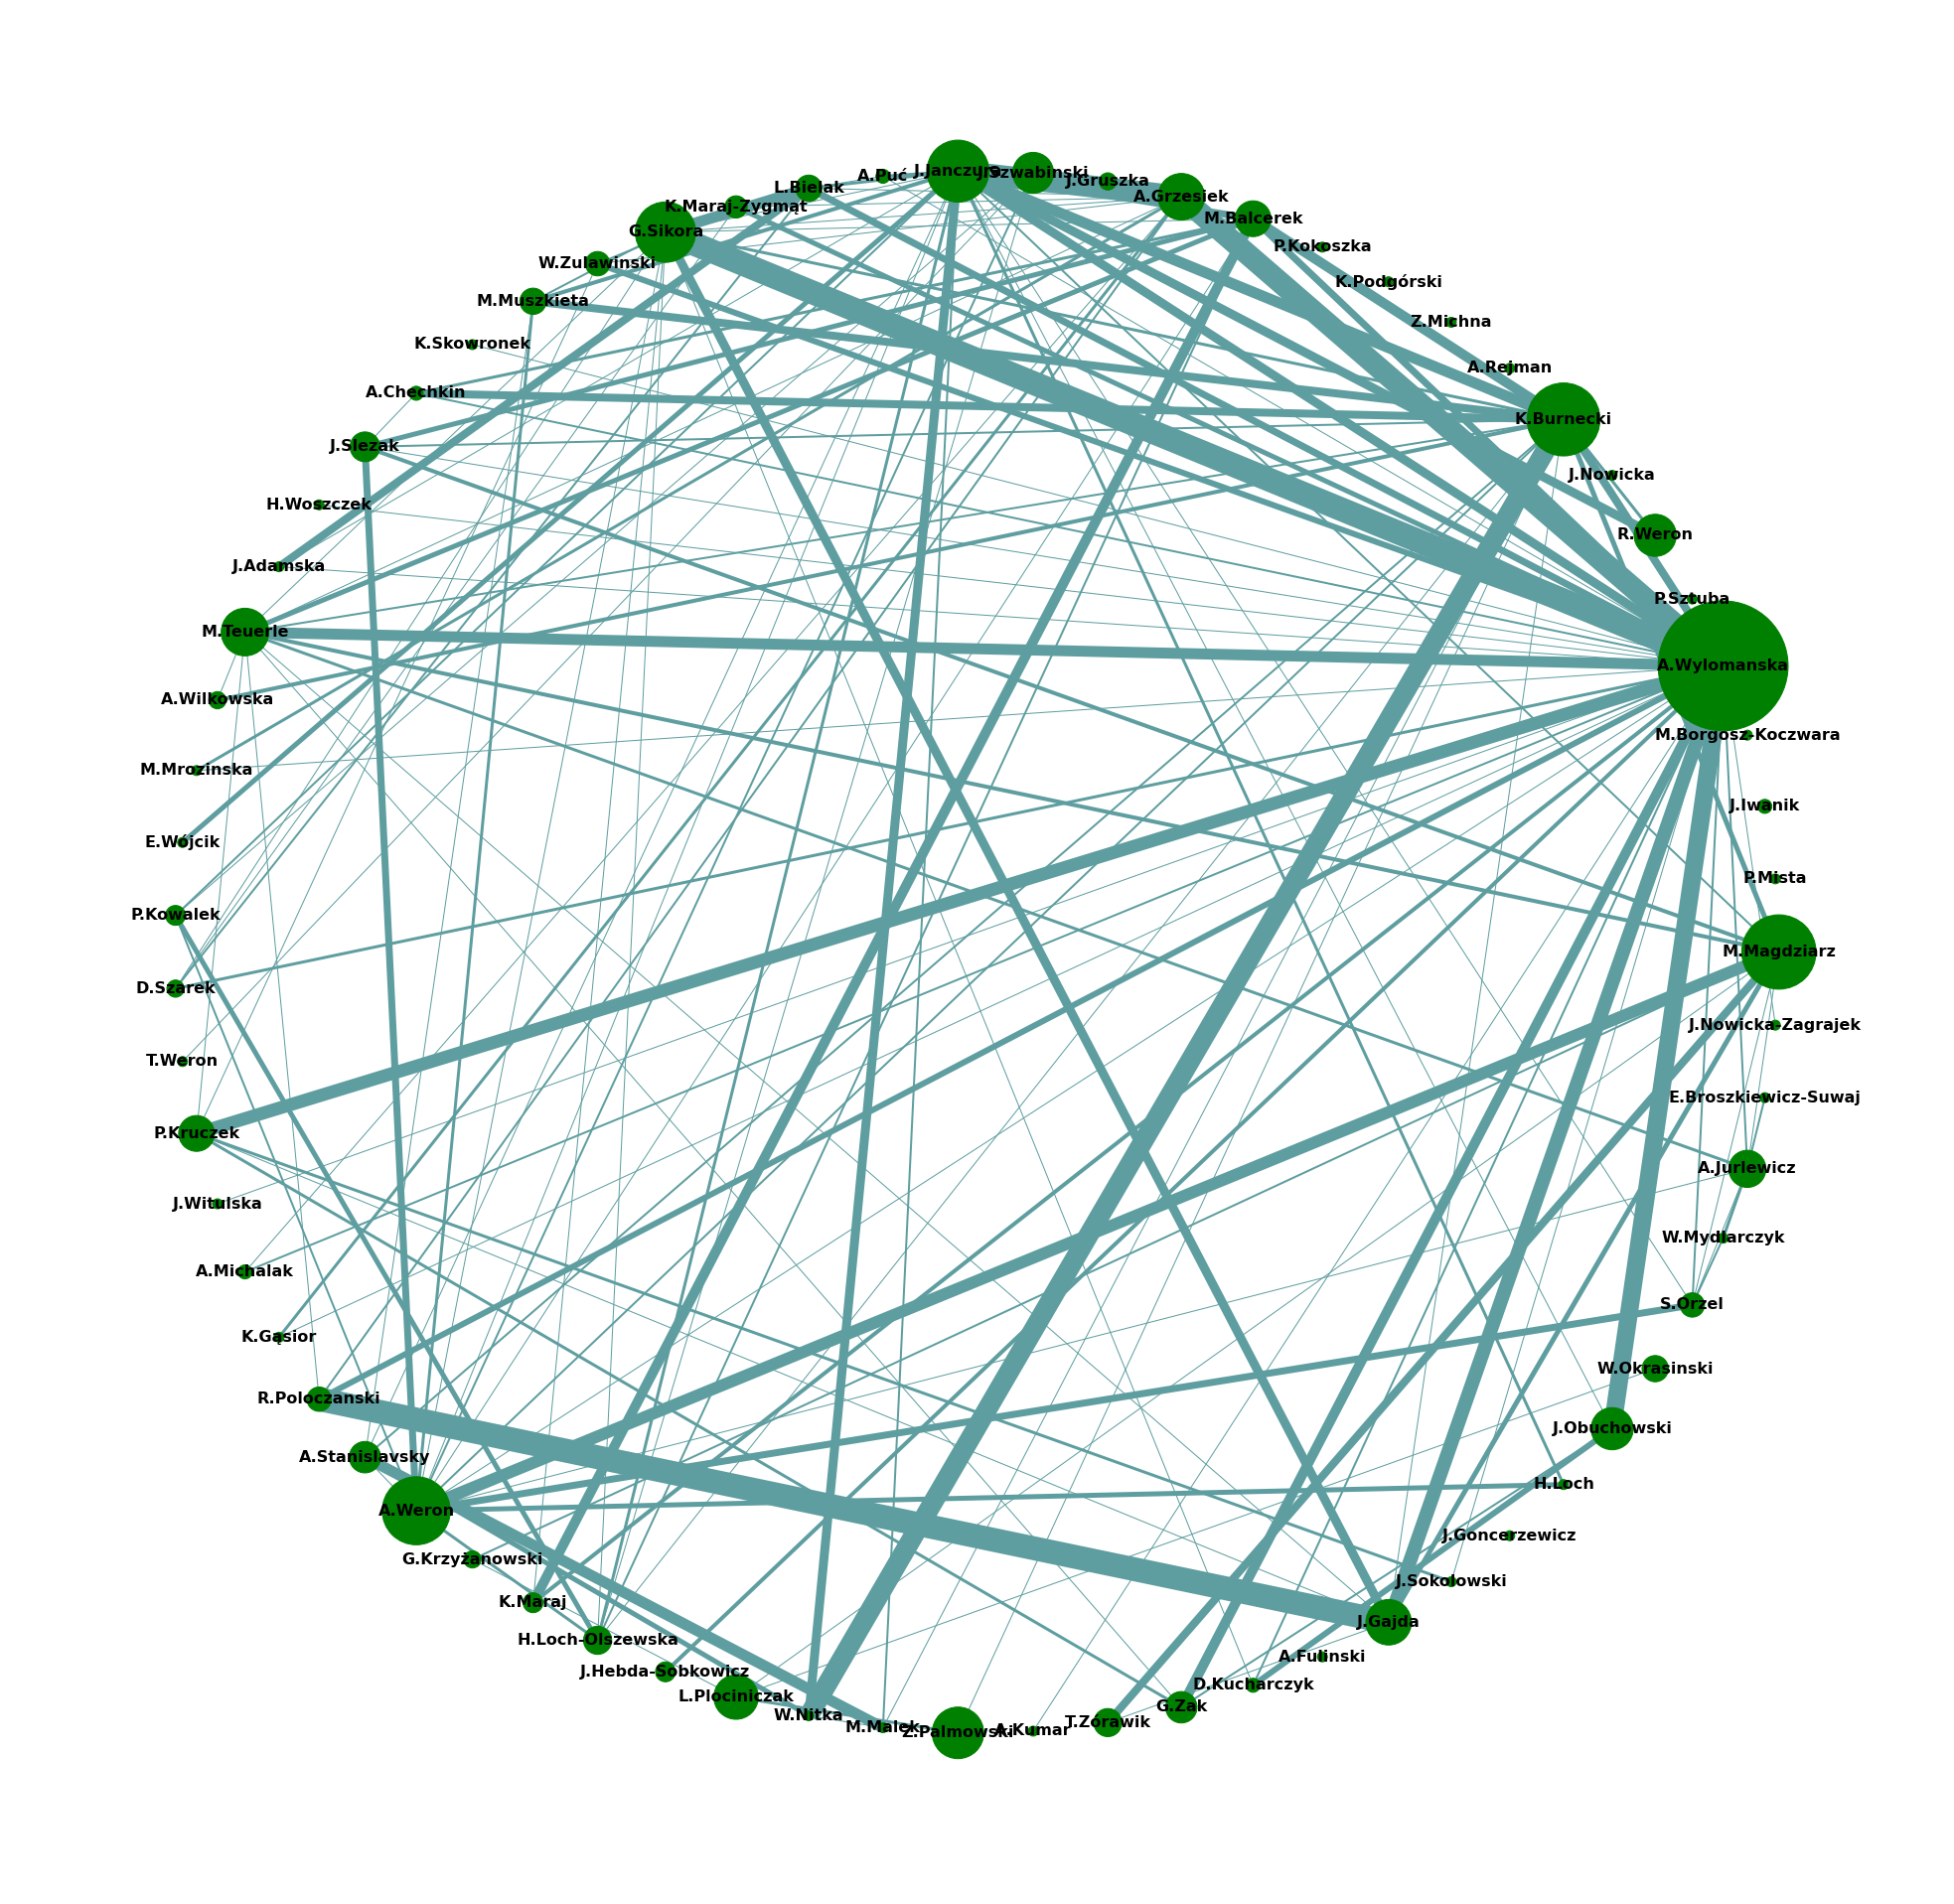

In [6]:
edges = []
weights = []
G = nx.empty_graph(0)
n = len(hcs_members)
for i in range(n):
    G.add_node(hcs_members[i])
for i in range(n):
    if(collabs[i] != []): 
        for collab in collabs[i]:
            edge = sorted((hcs_members[i], collab[0]))
            if edge not in edges:
                edges = edges + []
                weights = weights + [collab[1]]
                G.add_edge(*edge, weight = collab[1])
plt.figure(1,figsize = (35,35)) 
nodes = [i*100 for i in total_papers]
nx.draw_networkx(G, pos = nx.circular_layout(G),  
                          edge_color = '#5F9EA0', 
                          width = weights,  
                          node_color = 'green',
                          node_size = nodes,
                          with_labels = True,
                          font_size = 16, 
                          font_weight = 'bold')
limits = plt.axis('off')
plt.savefig("Network.pdf")